In [1]:
import tensorflow as tf

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten, BatchNormalization, LSTM
from keras.optimizers import Adam
from keras.regularizers import l2, l1, l1_l2

# from spektral.layers import GraphConv
# GRaphConv is deprecated, use GCNConv or GCSConv instead
from spektral.utils.sparse import sp_matrix_to_sp_tensor
from spektral.utils import normalized_laplacian
from spektral.layers import GCSConv  # as GraphConv
from spektral.layers import GINConv # as GraphConv
from spektral.layers import GCNConv  # as GraphConv

from spektral.utils.convolution import gcn_filter  # For GCNConv
from spektral.utils.convolution import normalized_adjacency  # For GCSConv

import numpy as np
import scipy.sparse
import pandas as pd
import pathlib
import os
import json

from sklearn.model_selection import train_test_split

from utils import *

import numpy as np

ModuleNotFoundError: No module named 'cv2'

In [11]:
!pip uninstall protobuf


^C


In [12]:
!pip install protobuf

You should consider upgrading via the 'C:\Users\Dell\OneDrive - vit.ac.in\Documents\Projects\Emotion_counselling\.venv\Scripts\python.exe -m pip install --upgrade pip' command.


In [1]:
!pip install mediapipe

  Using cached protobuf-4.25.8-cp310-abi3-win_amd64.whl (413 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.31.1
    Uninstalling protobuf-6.31.1:
      Successfully uninstalled protobuf-6.31.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires flatbuffers>=24.3.25, but you have flatbuffers 2.0.7 which is incompatible.
grpcio-status 1.74.0 requires protobuf<7.0.0,>=6.31.1, but you have protobuf 4.25.8 which is incompatible.
You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import mediapipe as mp
print(mp.__version__)


0.10.21


In [2]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from spektral.layers import GINConv, GCNConv
from spektral.utils.sparse import sp_matrix_to_sp_tensor

import numpy as np
import scipy.sparse
import pandas as pd
import pathlib
import os
import json
from sklearn.model_selection import train_test_split
from mediapipe.python.solutions.face_mesh_connections import FACEMESH_TESSELATION

# Parameters
l2_reg = 5e-4
learning_rate = 1e-3
batch_size = 32
epochs = 5
es_patience = 200
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)



In [5]:
def get_mediapipe_adjacency_matrix():
    """Create adjacency matrix from MediaPipe face mesh connections"""
    # MediaPipe face mesh has 468 landmarks
    n_nodes = 468
    adj_matrix = np.zeros((n_nodes, n_nodes), dtype=np.float32)
    
    # Add edges based on MediaPipe face mesh connections
    for connection in FACEMESH_TESSELATION:
        i, j = connection[0], connection[1]
        if i < n_nodes and j < n_nodes:  # Ensure indices are valid
            adj_matrix[i, j] = 1.0
            adj_matrix[j, i] = 1.0  # Undirected graph
    
    # Add self-loops
    np.fill_diagonal(adj_matrix, 1.0)
    
    return adj_matrix

def normalize_mesh_points(mesh_points):
    """Normalize mesh points to unit scale"""
    mesh_points = np.array(mesh_points, dtype=np.float32)
    
    # Center the points
    center = np.mean(mesh_points, axis=0)
    mesh_points = mesh_points - center
    
    # Scale to unit variance
    scale = np.std(mesh_points)
    if scale > 0:
        mesh_points = mesh_points / scale
    
    return mesh_points

def load_mesh_data(path_list, limit=1.0):
    """Load and preprocess mesh data from directories"""
    all_meshes = []
    all_labels = []
    
    for emotion_idx, path in enumerate(path_list):
        if not path.exists():
            print(f"Path does not exist: {path}")
            continue
            
        files = os.listdir(path)
        num_files = len(files)
        files_to_process = int(num_files * limit)
        
        emotion_meshes = []
        processed = 0
        
        for file in files[:files_to_process]:
            if not file.endswith('.json'):
                continue
                
            file_path = path / file
            try:
                with open(file_path, 'r') as f:
                    data = json.load(f)
                    
                # Ensure we have exactly 468 landmarks
                if len(data) != 468:
                    print(f"Skipping {file}: expected 468 landmarks, got {len(data)}")
                    continue
                
                # Normalize the mesh points
                normalized_mesh = normalize_mesh_points(data)
                emotion_meshes.append(normalized_mesh)
                processed += 1
                
            except Exception as e:
                print(f"Error loading {file}: {e}")
                continue
        
        print(f"Loaded {processed} samples for emotion {emotion_idx}")
        
        # Add to overall lists
        all_meshes.extend(emotion_meshes)
        all_labels.extend([emotion_idx] * len(emotion_meshes))
    
    return np.array(all_meshes, dtype=np.float32), np.array(all_labels, dtype=np.int32)



In [6]:
# Define paths
current_path = pathlib.Path().absolute()
parent_path = current_path.parent

path_list = [
    parent_path / 'angry_meshpoints',
    parent_path / 'disgusted_meshpoints', 
    parent_path / 'happy_meshpoints',
    parent_path / 'neutral_meshpoints',
    parent_path / 'sad_meshpoints',
    parent_path / 'surprised_meshpoints'
]

emotion_names = ['angry', 'disgusted', 'happy', 'neutral', 'sad', 'surprised']

print("Loading mesh data...")
X_data, y_data = load_mesh_data(path_list, limit=1.0)

print(f"Total samples loaded: {len(X_data)}")
print(f"Data shape: {X_data.shape}")
print(f"Labels shape: {y_data.shape}")

# Print class distribution
unique, counts = np.unique(y_data, return_counts=True)
for emotion_idx, count in zip(unique, counts):
    print(f"{emotion_names[emotion_idx]}: {count} samples")

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, shuffle=True, random_state=RANDOM_SEED, stratify=y_data
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=True, random_state=RANDOM_SEED, stratify=y_train
)

print(f"Train samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Convert to TensorFlow tensors
X_train_tensor = tf.constant(X_train, dtype=tf.float32)
y_train_tensor = tf.constant(y_train, dtype=tf.int32)
X_val_tensor = tf.constant(X_val, dtype=tf.float32)
y_val_tensor = tf.constant(y_val, dtype=tf.int32)
X_test_tensor = tf.constant(X_test, dtype=tf.float32)
y_test_tensor = tf.constant(y_test, dtype=tf.int32)

print(f"Train tensor shape: {X_train_tensor.shape}")
print(f"Train labels shape: {y_train_tensor.shape}")

# Model parameters
n_out = 6  # Number of emotion classes
N = X_train_tensor.shape[1]  # Number of nodes (468)
F = X_train_tensor.shape[2]  # Feature dimensionality (2 for x,y coordinates)

print(f"Number of nodes: {N}")
print(f"Number of features per node: {F}")

# Create adjacency matrix
print("Creating adjacency matrix...")
adj_matrix = get_mediapipe_adjacency_matrix()
print(f"Adjacency matrix shape: {adj_matrix.shape}")
print(f"Number of edges: {np.sum(adj_matrix > 0) // 2}")  # Divide by 2 for undirected graph

# Convert to sparse tensor for efficiency
adj_sparse = scipy.sparse.csr_matrix(adj_matrix)
adj_tensor = sp_matrix_to_sp_tensor(adj_sparse)




Loading mesh data...
Loaded 7603 samples for emotion 0
Loaded 6174 samples for emotion 1
Loaded 8681 samples for emotion 2
Loaded 9579 samples for emotion 3
Loaded 7965 samples for emotion 4
Loaded 8522 samples for emotion 5
Total samples loaded: 48524
Data shape: (48524, 468, 2)
Labels shape: (48524,)
angry: 7603 samples
disgusted: 6174 samples
happy: 8681 samples
neutral: 9579 samples
sad: 7965 samples
surprised: 8522 samples
Train samples: 31055
Validation samples: 7764
Test samples: 9705
Train tensor shape: (31055, 468, 2)
Train labels shape: (31055,)
Number of nodes: 468
Number of features per node: 2
Creating adjacency matrix...
Adjacency matrix shape: (468, 468)
Number of edges: 1556


V1

In [7]:
# Build the GNN model
print("Building model...")
X_in = Input(shape=(N, F), name='node_features')

# First GNN layer
x = GINConv(64, activation="relu", kernel_regularizer=l2(l2_reg))([X_in, adj_tensor])
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Second GNN layer
x = GINConv(32, activation="relu", kernel_regularizer=l2(l2_reg))([x, adj_tensor])
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Global pooling (flatten all node features)
x = Flatten()(x)

# Fully connected layers
x = Dense(256, activation="relu", kernel_regularizer=l2(l2_reg))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation="relu", kernel_regularizer=l2(l2_reg))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Output layer
output = Dense(n_out, activation="softmax", name='emotion_output')(x)

# Create and compile model
model = Model(inputs=X_in, outputs=output)
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Building model...



Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ node_features (InputLayer)      │ (None, 468, 2)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gin_conv (GINConv)              │ (None, 468, 64)        │           193 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 468, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 468, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gin_conv_1 (GINConv)            │ (None, 468, 32)        │         2,081 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 468, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 468, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     3,834,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ emotion_output (Dense)          │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,871,976 (14.77 MB)

 Trainable params: 3,871,016 (14.77 MB)

 Non-trainable params: 960 (3.75 KB)

V2 model 

In [9]:
from tensorflow.keras import Input, Model
from spektral.layers import GINConv
import tensorflow as tf

# Node features
X_in = Input(shape=(N, F), name="X_in")

# Adjacency matrix as a *sparse* input
A_in = Input(
    shape=(N, N),
    sparse=True,
    dtype=tf.float32,
    name="A_in",
)

# First GNN layer
x = GINConv(
    64,
    activation="relu",
    kernel_regularizer=l2(l2_reg)
)([X_in, A_in])
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# Second GNN layer
x = GINConv(
    32,
    activation="relu",
    kernel_regularizer=l2(l2_reg)
)([x, A_in])
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

# … the rest is the same …
x = Flatten()(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(l2_reg))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu", kernel_regularizer=l2(l2_reg))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(n_out, activation="softmax", name="emotion_output")(x)

# **Don’t forget** to include both inputs in the Model!
model = Model(inputs=[X_in, A_in], outputs=output)
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
model.summary()


AssertionError: Exception encountered when calling GINConv.call().

[1mCould not automatically infer the output shape / dtype of 'gin_conv_4' (of type GINConv). Either the `GINConv.call()` method is incorrect, or you need to implement the `GINConv.compute_output_spec() / compute_output_shape()` method. Error encountered:

A must have rank 2[0m

Arguments received by GINConv.call():
  • args=(['<KerasTensor shape=(None, 468, 2), dtype=float32, sparse=False, ragged=False, name=X_in>', '<KerasTensor shape=(None, 468, 468), dtype=float32, sparse=True, ragged=False, name=A_in>'],)
  • kwargs=<class 'inspect._empty'>

In [8]:
# Train the model
print("Starting training...")
history = model.fit(
    X_train_tensor,
    y_train_tensor,
    batch_size=batch_size,
    validation_data=(X_val_tensor, y_val_tensor),
    epochs=epochs*5,
    callbacks=[EarlyStopping(patience=es_patience, restore_best_weights=True)],
    verbose=1
)
print("Training completed!")


Starting training...
Epoch 1/25
971/971 ━━━━━━━━━━━━━━━━━━━━ 43s 42ms/step - accuracy: 0.3178 - loss: 2.3213 - val_accuracy: 0.4602 - val_loss: 1.7662
Epoch 2/25
971/971 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - accuracy: 0.4339 - loss: 1.8443 - val_accuracy: 0.4361 - val_loss: 1.8030
Epoch 3/25
971/971 ━━━━━━━━━━━━━━━━━━━━ 53s 54ms/step - accuracy: 0.4557 - loss: 1.7329 - val_accuracy: 0.4769 - val_loss: 1.6532
Epoch 4/25
971/971 ━━━━━━━━━━━━━━━━━━━━ 59s 60ms/step - accuracy: 0.4629 - loss: 1.7095 - val_accuracy: 0.4648 - val_loss: 1.6702
Epoch 5/25
971/971 ━━━━━━━━━━━━━━━━━━━━ 60s 61ms/step - accuracy: 0.4599 - loss: 1.7143 - val_accuracy: 0.4295 - val_loss: 1.7442
Epoch 6/25
971/971 ━━━━━━━━━━━━━━━━━━━━ 59s 61ms/step - accuracy: 0.4622 - loss: 1.7039 - val_accuracy: 0.4776 - val_loss: 1.6362
Epoch 7/25
971/971 ━━━━━━━━━━━━━━━━━━━━ 59s 61ms/step - accuracy: 0.4597 - loss: 1.6893 - val_accuracy: 0.4087 - val_loss: 1.8092
Epoch 8/25
971/971 ━━━━━━━━━━━━━━━━━━━━ 59s 60ms/step - accuracy: 0.4


Evaluating on test set...
Test Loss: 1.4855
Test Accuracy: 0.5144


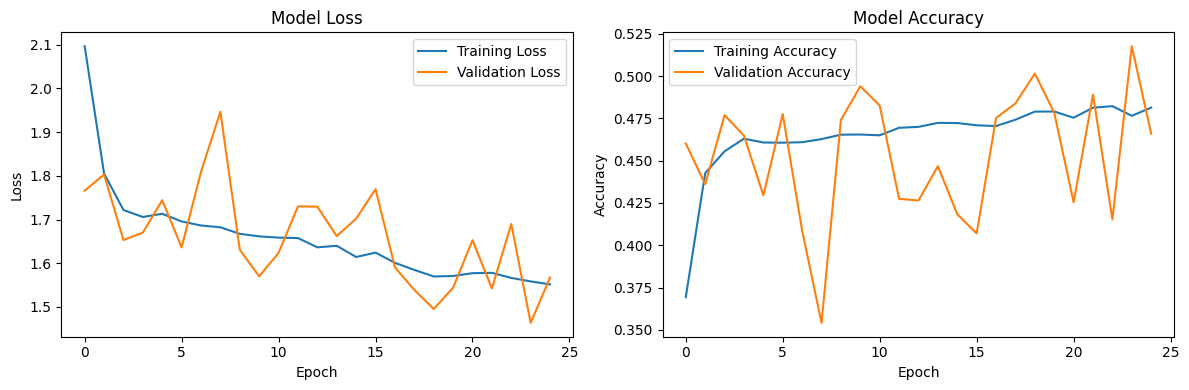

In [9]:
# Evaluate on test set
print("\nEvaluating on test set...")
test_loss, test_accuracy = model.evaluate(X_test_tensor, y_test_tensor, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


You should consider upgrading via the 'C:\Users\Dell\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [10]:
model.save_weights("gnn_face_emotion2.weights.h5")


In [8]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from spektral.layers import GINConv
from spektral.utils.sparse import sp_matrix_to_sp_tensor
import scipy.sparse
import numpy as np

# Function to compute adjacency and sparse tensor

def get_mediapipe_adj_tensor():
    adj = get_mediapipe_adjacency_matrix()  # your existing function
    adj_sp = scipy.sparse.csr_matrix(adj)
    return sp_matrix_to_sp_tensor(adj_sp)

# Build function
def build_gnn_face_emotion_model(
    N: int,
    F: int,
    n_out: int,
    l2_reg: float = 5e-4,
    learning_rate: float = 1e-3
) -> tf.keras.Model:
    """
    Builds and compiles the GNN face emotion classification model.

    Args:
        N: Number of nodes (e.g., 468).
        F: Feature dimensionality per node (e.g., 2 for x, y).
        n_out: Number of emotion classes.
        l2_reg: L2 regularization factor.
        learning_rate: Learning rate for the Adam optimizer.

    Returns:
        A compiled tf.keras.Model instance.
    """
    # Prepare adjacency as sparse tensor
    adj_tensor = get_mediapipe_adj_tensor()

    # Input for node features
    X_in = Input(shape=(N, F), name='node_features')

    # First GNN block
    x = GINConv(64, activation='relu', kernel_regularizer=l2(l2_reg))([X_in, adj_tensor])
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Second GNN block
    x = GINConv(32, activation='relu', kernel_regularizer=l2(l2_reg))([x, adj_tensor])
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Global pooling (flatten)
    x = Flatten()(x)

    # Dense layers
    x = Dense(256, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output
    output = Dense(n_out, activation='softmax', name='emotion_output')(x)

    # Model
    model = Model(inputs=X_in, outputs=output)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Example usage:
# model = build_gnn_face_emotion_model(N=468, F=2, n_out=6)
# model.summary()


In [9]:
# (Re)define your `build_model()` exactly as you did originally,
# including the `get_mediapipe_adjacency_matrix() + sp_matrix_to_sp_tensor` call.
model = build_gnn_face_emotion_model(N=468, F=2, n_out=6)  
model.load_weights("gnn_face_emotion2.weights.h5")

c:\Users\Dell\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import mediapipe as mp
from spektral.layers import GINConv
from spektral.utils.sparse import sp_matrix_to_sp_tensor
import scipy.sparse
from mediapipe.python.solutions.face_mesh_connections import FACEMESH_TESSELATION
import time

def get_mediapipe_adjacency_matrix():
    """Create adjacency matrix from MediaPipe face mesh connections"""
    # MediaPipe face mesh has 468 landmarks (without iris when refine_landmarks=False)
    n_nodes = 468
    adj_matrix = np.zeros((n_nodes, n_nodes), dtype=np.float32)
    
    # Add edges based on MediaPipe face mesh connections
    for connection in FACEMESH_TESSELATION:
        i, j = connection[0], connection[1]
        if i < n_nodes and j < n_nodes:  # Ensure indices are valid for 468 landmarks
            adj_matrix[i, j] = 1.0
            adj_matrix[j, i] = 1.0  # Undirected graph
    
    # Add self-loops
    np.fill_diagonal(adj_matrix, 1.0)
    
    return adj_matrix

# --- Constants and Initializations ---
# Define the emotion labels in the same order as your training data
EMOTIONS = ["Angry", "Disgusted", "Happy", "Neutral", "Sad", "Surprised"]

# Emotion colors for display (BGR format for OpenCV)
EMOTION_COLORS = {
    "Angry": (0, 0, 255),      # Red
    "Disgusted": (0, 128, 0),  # Green
    "Happy": (0, 255, 255),    # Yellow
    "Neutral": (128, 128, 128), # Gray
    "Sad": (255, 0, 0),        # Blue
    "Surprised": (0, 165, 255) # Orange
}

# Load the trained model with improved method
try:
    print("Loading trained GNN model...")
    from model_utils import load_model_with_validation
    model, metadata, adj_tensor_loaded = load_model_with_validation("emotion_gnn_model.h5")
    
    if model is None:
        print("❌ Could not load model. Make sure you've trained the model first.")
        exit()
        
    print("✅ Model loaded successfully.")
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Make sure 'emotion_gnn_model.h5' exists and was trained with the GNN code.")
    exit()

# Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
face_mesh = mp_face_mesh.FaceMesh(
    max_num_faces=1, 
    refine_landmarks=False,  # Use 468 landmarks (no iris)
    min_detection_confidence=0.7, 
    min_tracking_confidence=0.5
)

# Create adjacency matrix for the model
print("Creating adjacency matrix...")
adj_matrix = get_mediapipe_adjacency_matrix()
adj_sparse = scipy.sparse.csr_matrix(adj_matrix)
adj_tensor = sp_matrix_to_sp_tensor(adj_sparse)

print(f"Adjacency matrix shape: {adj_matrix.shape}")
print(f"Number of edges: {np.sum(adj_matrix > 0) // 2}")

# Prediction smoothing
prediction_history = []
history_size = 5  # Number of frames to average for smoothing

def normalize_mesh_points(mesh_points):
    """Normalize mesh points to match training data preprocessing"""
    mesh_points = np.array(mesh_points, dtype=np.float32)
    
    # Center the points
    center = np.mean(mesh_points, axis=0)
    mesh_points = mesh_points - center
    
    # Scale to unit variance
    scale = np.std(mesh_points)
    if scale > 0:
        mesh_points = mesh_points / scale
    
    return mesh_points

def draw_prediction_bars(frame, predictions, current_emotion):
    """Draw probability bars for all emotions"""
    bar_width = 200
    bar_height = 25
    start_x = 10
    start_y = 80
    
    for i, (emotion, prob) in enumerate(zip(EMOTIONS, predictions[0])):
        y_pos = start_y + i * (bar_height + 5)
        
        # Background bar
        cv2.rectangle(frame, (start_x, y_pos), (start_x + bar_width, y_pos + bar_height), 
                     (50, 50, 50), -1)
        
        # Probability bar
        fill_width = int(bar_width * prob)
        color = EMOTION_COLORS[emotion] if emotion == current_emotion else (100, 100, 100)
        cv2.rectangle(frame, (start_x, y_pos), (start_x + fill_width, y_pos + bar_height), 
                     color, -1)
        
        # Text label
        cv2.putText(frame, f"{emotion}: {prob:.1%}", (start_x + bar_width + 10, y_pos + 18), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1, cv2.LINE_AA)

# --- Main Webcam Loop ---
print("Starting webcam...")
print("Press 'q' to quit, 's' to save current frame, 'r' to reset prediction history")

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("❌ Error: Could not open webcam.")
    exit()

# Set camera properties for better performance
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
cap.set(cv2.CAP_PROP_FPS, 30)

frame_count = 0
fps_start_time = time.time()
fps = 0

while True:
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame")
        break

    frame_count += 1
    H, W, _ = frame.shape
    
    # Calculate FPS
    if frame_count % 30 == 0:
        fps_end_time = time.time()
        fps = 30 / (fps_end_time - fps_start_time)
        fps_start_time = fps_end_time

    # Flip frame horizontally for mirror effect
    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Process the frame with MediaPipe
    results = face_mesh.process(rgb_frame)

    if results.multi_face_landmarks:
        # Use the landmarks of the first detected face
        face_landmarks = results.multi_face_landmarks[0]
        
        # --- Extract and preprocess landmarks for the model ---
        # 1. Extract X, Y coordinates
        mesh_points = np.array(
            [[p.x * W, p.y * H] for p in face_landmarks.landmark],
            dtype=np.float32
        )
        
        print(f"Number of landmarks detected: {len(mesh_points)}")  # Should be 468
        
        # 2. Normalize the landmarks (same as training)
        normalized_points = normalize_mesh_points(mesh_points)
        
        # 3. Reshape for the model input (add batch dimension)
        model_input = np.expand_dims(normalized_points, axis=0)
        
        try:
            # --- Predict Emotion ---
            prediction = model.predict(model_input, verbose=0)
            
            # Add to prediction history for smoothing
            prediction_history.append(prediction[0])
            if len(prediction_history) > history_size:
                prediction_history.pop(0)
            
            # Average predictions for smoother results
            smoothed_prediction = np.mean(prediction_history, axis=0)
            emotion_index = np.argmax(smoothed_prediction)
            emotion_label = EMOTIONS[emotion_index]
            confidence = smoothed_prediction[emotion_index]
            
            # --- Display the result on the frame ---
            # Draw face bounding box
            x_min = int(np.min(mesh_points[:, 0])) - 20
            y_min = int(np.min(mesh_points[:, 1])) - 20
            x_max = int(np.max(mesh_points[:, 0])) + 20
            y_max = int(np.max(mesh_points[:, 1])) + 20
            
            # Draw bounding box with emotion color
            color = EMOTION_COLORS[emotion_label]
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), color, 3)
            
            # Display the emotion label and confidence
            text = f"{emotion_label}: {confidence:.1%}"
            text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 1.0, 2)[0]
            
            # Background for text
            cv2.rectangle(frame, (x_min, y_min - 40), 
                         (x_min + text_size[0] + 10, y_min), color, -1)
            
            # Text
            cv2.putText(frame, text, (x_min + 5, y_min - 10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255, 255, 255), 2, cv2.LINE_AA)
            
            # Draw face mesh (optional - can be disabled for better performance)
            # mp_drawing.draw_landmarks(
            #     frame, face_landmarks, mp_face_mesh.FACEMESH_CONTOURS,
            #     landmark_drawing_spec=None,
            #     connection_drawing_spec=mp_drawing.DrawingSpec(
            #         color=(0, 255, 0), thickness=1, circle_radius=1)
            # )
            
            # Draw prediction bars
            draw_prediction_bars(frame, [smoothed_prediction], emotion_label)
            
        except Exception as e:
            print(f"Prediction error: {e}")
            cv2.putText(frame, "Prediction Error", (20, 40), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

    else:
        cv2.putText(frame, "No Face Detected", (20, 40), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        # Clear prediction history when no face is detected
        prediction_history.clear()

    # Display FPS
    cv2.putText(frame, f"FPS: {fps:.1f}", (W - 120, 30), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    
    # Display instructions
    cv2.putText(frame, "Press 'q' to quit, 'r' to reset", (10, H - 20), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    # Show the final frame
    cv2.imshow('Facial Emotion Recognition (GNN)', frame)

    # Handle key presses
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('r'):
        prediction_history.clear()
        print("Prediction history reset")
    elif key == ord('s'):
        filename = f"emotion_frame_{int(time.time())}.jpg"
        cv2.imwrite(filename, frame)
        print(f"Frame saved as {filename}")

print("Shutting down...")

# --- Cleanup ---
cap.release()
cv2.waitKey(1) 
cv2.destroyAllWindows()
cv2.waitKey(1)
face_mesh.close()

print("✅ Application closed successfully.")

Loading trained GNN model...
❌ Error loading model: No module named 'model_utils'
Make sure 'emotion_gnn_model.h5' exists and was trained with the GNN code.
Creating adjacency matrix...
Adjacency matrix shape: (468, 468)
Number of edges: 1556
Starting webcam...
Press 'q' to quit, 's' to save current frame, 'r' to reset prediction history
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of landmarks detected: 468
Number of land

: 

In [3]:
# Parameters
l2_reg = 5e-4  # Regularization rate for l2
learning_rate = 1e-3  # Learning rate for SGD
batch_size = 32  # Batch size
epochs = 5  # Number of training epochs
es_patience = 200  # Patience fot early stopping

In [4]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [5]:
current_path = pathlib.Path().absolute()
path = current_path.parent

In [6]:
angry_path = path / 'angry_meshpoints'
disgusted_path = path / 'disgusted_meshpoints'
happy_path = path / 'happy_meshpoints'
neutral_path = path / 'neutral_meshpoints'
sad_path = path / 'sad_meshpoints'
surprised_path = path / 'surprised_meshpoints'

path_list = [angry_path, disgusted_path, happy_path, neutral_path, sad_path, surprised_path]

In [7]:
def extrai_dist(path_list, meshs_list, limit=0.1):
    for path in path_list:
        quant_files = len(os.listdir(path))
        count = 0
        for file in os.listdir(path):
            if (count / quant_files) > limit:
                break
            file_path = path / file
            count += 1
            with open(file_path, 'r') as f:
                data = json.load(f)
                meshs_list[path_list.index(path)].append(data)

In [8]:
meshs_surprised = []
meshs_disgusted = []
meshs_happy = []
meshs_neutral = []
meshs_sad = []
meshs_angry = []

meshs_list = [meshs_angry, meshs_disgusted, meshs_happy, meshs_neutral, meshs_sad, meshs_surprised]

extrai_dist(path_list, meshs_list, 1)

print(len(meshs_angry))
print(len(meshs_disgusted))
print(len(meshs_happy))
print(len(meshs_neutral))
print(len(meshs_sad))
print(len(meshs_surprised))

22
19
22
21
21
22


In [9]:
for list in meshs_list:
    print(len(list))

22
19
22
21
21
22


In [9]:
# print(meshs_list)

In [10]:
print(len(meshs_list))

6


In [11]:
# target list
target_list = []
for i in range(6):
    target_list.append(np.full(len(meshs_list[i]), i))

In [12]:
# print(target_list)

In [12]:
# print the unique target labels
print(np.unique(np.concatenate(target_list)))

[0 1 2 3 4 5]


In [13]:
# concatena meshs_list em uma lista só
meshs_list_concat = np.concatenate(meshs_list)
target_list_concat = np.concatenate(target_list)

print(len(meshs_list_concat))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (22,) + inhomogeneous part.

# Iniciando a construção do primeiro GINConv

In [14]:
from sklearn.model_selection import train_test_split


# Split the dataset into train and test sets, shuffling the data
X_train, X_test, y_train, y_test = train_test_split(meshs_list_concat, target_list_concat, test_size=0.2, shuffle=True, random_state=42)

# Split the train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=42)

NameError: name 'meshs_list_concat' is not defined

In [18]:
# import concat from tensorflow
from tensorflow import concat

# tensor_mesh = concat(meshs_list, axis=0)
# target_tensor = concat(target_list, axis=0)

X__train_tensor = concat(X_train, axis=0)
y__train_tensor = concat(y_train, axis=0)

X__val_tensor = concat(X_val, axis=0)
y__val_tensor = concat(y_val, axis=0)

X__test_tensor = concat(X_test, axis=0)
y__test_tensor = concat(y_test, axis=0)

In [19]:
for target_tensor in [y__train_tensor, y__val_tensor, y__test_tensor]:
    unique_values = np.unique(target_tensor.numpy())
    print("Unique values in target tensor:")
    print(unique_values)
    print()

Unique values in target tensor:
[0 1 2 3 4 5]

Unique values in target tensor:
[0 1 2 3 4 5]

Unique values in target tensor:
[0 1 2 3 4 5]



In [20]:
# tensor_mesh.shape
X__train_tensor.shape

TensorShape([27968, 478, 2])

In [21]:
# target_tensor.shape
y__train_tensor.shape

TensorShape([27968])

In [22]:
X__val_tensor.shape

TensorShape([6992, 478, 2])

In [23]:
y__val_tensor.shape

TensorShape([6992])

In [24]:
n_out = 6  # Number of classes
N = X__train_tensor.shape[-2]  # Number of nodes in the graphs
F = X__train_tensor.shape[-1]  # Original feature dimensionality

In [25]:
N, F

(478, 2)

In [26]:
# import the dropout layer
from tensorflow.keras.layers import Dropout

tanh
signmoid snht
relu
leaky_relu
elu
celu
selu
softplus
softshrink
softsign
tanhshrink
prelu
rrelu
glu
gelu
hardshrink
hardtanh
logsigmoid

In [27]:
adj = tf.sparse.from_dense(tf.convert_to_tensor(get_mediapipe_adjacency_matrix()))

X_in = Input(shape=(N, F))

graph_conv_1 = GINConv(32, activation="tanh", kernel_regularizer=l2(l2_reg), use_bias=True)([X_in, adj])
graph_conv_drop1 = Dropout(0.25)(graph_conv_1)
graph_conv_2 = GINConv(32, activation="tanh", kernel_regularizer=l2(l2_reg), use_bias=True)([graph_conv_drop1, adj])

flatten = Flatten()(graph_conv_2)
fc = Dense(512, activation="relu")(flatten)
fc = Dense(256, activation="mish")(fc)
fc = Dense(128, activation="relu")(fc)
output = Dense(n_out, activation="softmax")(fc)

In [28]:
# Build model
model = Model(inputs=X_in, outputs=output)
optimizer = Adam(learning_rate=learning_rate)
model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["acc"]
)

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 478, 2)]          0         
                                                                 
 gin_conv (GINConv)          (None, 478, 32)           97        
                                                                 
 dropout (Dropout)           (None, 478, 32)           0         
                                                                 
 gin_conv_1 (GINConv)        (None, 478, 32)           1057      
                                                                 
 flatten (Flatten)           (None, 15296)             0         
                                                                 
 dense (Dense)               (None, 512)               7832064   
                                                                 
 dense_1 (Dense)             (None, 256)               131328

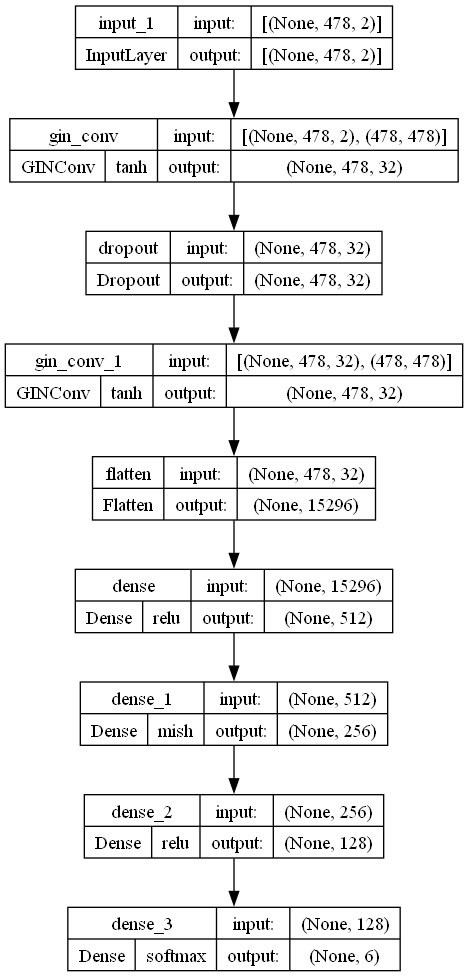

In [35]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [52]:
# o tensor_mesh é um tensor de dimensão 3
# o sparse_matrix é um tensor de dimensão 2
# o target_list é um tensor de dimensão 1

# Train model
history = model.fit(
    X__train_tensor,
    y__train_tensor,
    batch_size=batch_size,
    validation_data=(X__val_tensor, y__val_tensor),
    epochs=epochs*5,
    callbacks=[EarlyStopping(patience=es_patience)],
)

Epoch 1/25


873/873 [==============================] - 66s 74ms/step - loss: 1.5862 - acc: 0.4276 - val_loss: 1.3420 - val_acc: 0.4841
Epoch 2/25
873/873 [==============================] - 77s 88ms/step - loss: 1.3197 - acc: 0.4860 - val_loss: 1.2619 - val_acc: 0.5185
Epoch 3/25
873/873 [==============================] - 86s 98ms/step - loss: 1.2786 - acc: 0.5055 - val_loss: 1.2255 - val_acc: 0.5358
Epoch 4/25
873/873 [==============================] - 81s 92ms/step - loss: 1.2381 - acc: 0.5207 - val_loss: 1.2161 - val_acc: 0.5367
Epoch 5/25
873/873 [==============================] - 72s 82ms/step - loss: 1.2195 - acc: 0.5297 - val_loss: 1.1836 - val_acc: 0.5501
Epoch 6/25
873/873 [==============================] - 54s 62ms/step - loss: 1.1958 - acc: 0.5397 - val_loss: 1.1908 - val_acc: 0.5550
Epoch 7/25
873/873 [==============================] - 52s 59ms/step - loss: 1.1843 - acc: 0.5417 - val_loss: 1.1647 - val_acc: 0.5530
Epoch 8/25
873/873 [==============================] - 56s 64ms/step - los

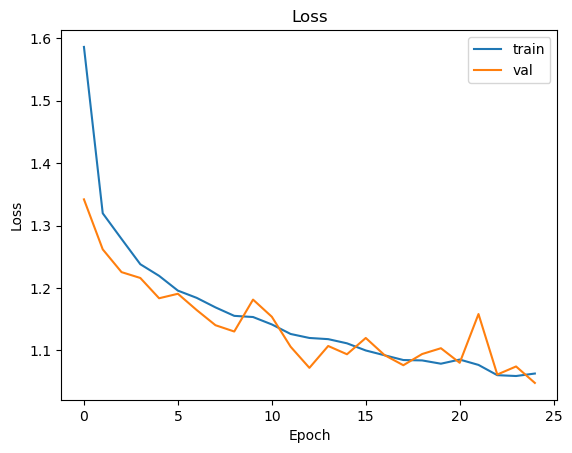

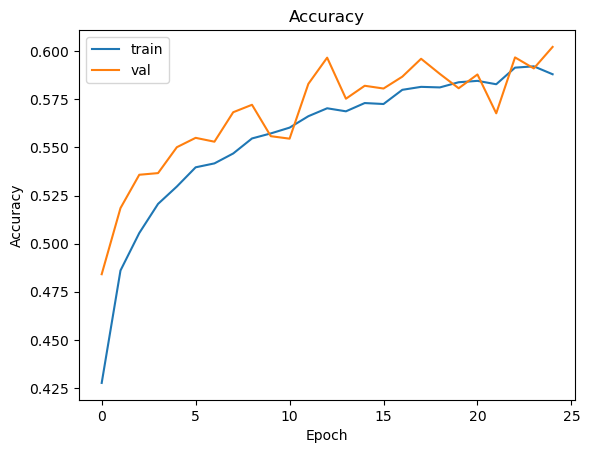

In [62]:
# ploting the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Loss")
plt.legend()
plt.savefig('loss.png', dpi=300)
plt.show()

plt.plot(history.history["acc"], label="train")
plt.plot(history.history["val_acc"], label="val")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Accuracy")
plt.legend()
# save with 300 dpi
plt.savefig('loss_acc.png', dpi=300)
plt.show()

Como o dempenho caiu muita rápido através das epochs, pode ser que o modelo esteja com um overfitting muito grande.

219/219 [==============================] - 2s 10ms/step


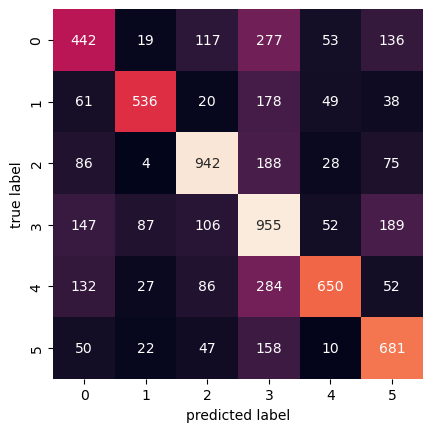

In [61]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X__val_tensor)
y_pred = np.argmax(y_pred, axis=-1)
y_true = y__val_tensor

mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat, square=True, annot=True, fmt="d", cbar=False)
plt.ylabel("true label")
plt.xlabel("predicted label")
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

Ta.... ta uma bosta